In [1]:
import os
import io
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
sess = tf.Session()
%matplotlib inline

In [2]:
#We will now create a summary writer that can write Tensorboard summaries to Tensorboard summaries to a Tensorboard folder

#Create a visualizer object
summary_writer = tf.summary.FileWriter('tensorboard', tf.get_default_graph())

In [3]:
#We need to make sure that the Tensorboard folder exists for the summary writer to write the Tensorboard logs
if not os.path.exists('tensorboard'):
    os.makedirs('tensorboard')

In [4]:
#We will now set the model parameters and generate the linear data for the model. Note that our true slope is 2, and we
#will visualize the changing slope over time and see it approach the true value
batch_size = 50
generations = 100

#Create simple input data
x_data = np.arange(1000)/10.
true_slope = 2.
y_data = x_data * true_slope + np.random.normal(loc=0.0, scale=25, size=1000)

In [5]:
#Next we will split the dataset into a train and test set
train_ix = np.random.choice(len(x_data), size=int(len(x_data)*0.9),replace=False)
test_ix = np.setdiff1d(np.arange(1000), train_ix)
x_data_train, y_data_train = x_data[train_ix], y_data[train_ix]
x_data_test , y_data_test = x_data[test_ix], y_data[test_ix]

In [6]:
#Now we can create the placeholders, variables, model operations, loss and optimizing operations

# Declare placeholders
x_graph_input = tf.placeholder(tf.float32, [None])
y_graph_input = tf.placeholder(tf.float32, [None])

# Declare model variables
m = tf.Variable(tf.random_normal([1], dtype=tf.float32), name='Slope')

# Declare model
output = tf.multiply(m, x_graph_input, name='Batch_Multiplication')

# Declare loss function (L1)
residuals = output - y_graph_input
l1_loss = tf.reduce_mean(tf.abs(residuals), name="L1_Loss")

# Declare optimization function
my_optim = tf.train.GradientDescentOptimizer(0.01)
train_step = my_optim.minimize(l1_loss)

In [7]:
#We can now create a Tensorboard operation that will summarize a scalar value. The scalar value that we will summarize
#is the slope estimate of the model.
with tf.name_scope('Slope_Estimate'):
    tf.summary.scalar('Slope_Estimate', tf.squeeze(m))

In [8]:
#Another summary we can add to Tensorboard is a histogram summary, which inputs multiple values in a tensor and outputs 
#graphs and histograms
with tf.name_scope('Loss_and_Residuals'):
    tf.summary.histogram('Histogram_Errors', l1_loss)
    tf.summary.histogram('Histogram_Residuals', residuals)

In [9]:
#After creating these summary operations, we need to create a summary merging operation that will combine all the 
#summaries, and then we can initalize the model variables
summary_op = tf.summary.merge_all()
#Initialize Variables
init = tf.global_variables_initializer()
sess.run(init)

In [10]:
#Now we can train the linear model, and write summaries every generation
for i in range(generations):
    batch_indices = np.random.choice(len(x_data_train), size=batch_size)
    x_batch = x_data_train[batch_indices]
    y_batch = y_data_train[batch_indices]
    _, train_loss, summary = sess.run([train_step, l1_loss, summary_op],
                             feed_dict={x_graph_input: x_batch,
                                        y_graph_input: y_batch})
    
    test_loss, test_resids = sess.run([l1_loss, residuals], feed_dict={x_graph_input: x_data_test,
                                                                       y_graph_input: y_data_test})
    
    if (i+1)%10==0:
        print('Generation {} of {}. Train Loss: {:.3}, Test Loss: {:.3}.'.format(i+1, generations, train_loss, test_loss))

    log_writer = tf.summary.FileWriter('tensorboard')
    log_writer.add_summary(summary, i)
    time.sleep(0.5)

Generation 10 of 100. Train Loss: 22.0, Test Loss: 23.3.
Generation 20 of 100. Train Loss: 24.4, Test Loss: 23.8.
Generation 30 of 100. Train Loss: 22.2, Test Loss: 22.3.
Generation 40 of 100. Train Loss: 23.8, Test Loss: 22.3.
Generation 50 of 100. Train Loss: 19.0, Test Loss: 22.4.
Generation 60 of 100. Train Loss: 22.5, Test Loss: 22.6.
Generation 70 of 100. Train Loss: 22.1, Test Loss: 22.4.
Generation 80 of 100. Train Loss: 20.9, Test Loss: 22.6.
Generation 90 of 100. Train Loss: 21.9, Test Loss: 23.6.
Generation 100 of 100. Train Loss: 23.6, Test Loss: 22.7.


In [13]:
#In order to put the final graph of the linear fit with the data points in Tensorboard, we have to create a graph image
#in protobuff format. To start this, we will create a function that outputs a protobuff graph
def gen_linear_plot(slope):
    linear_prediction = x_data * slope
    plt.plot(x_data, y_data, 'b.', label='data')
    plt.plot(x_data, linear_prediction, 'r-', linewidth=3, label='predicted line')
    plt.legend(loc='upper left')
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    return(buf)

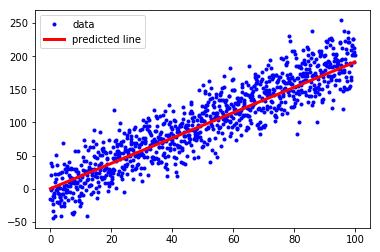

In [14]:
#Now we can create and add the protobuff image to Tensorboard

# Add image to tensorboard (plot the linear fit!)
slope = sess.run(m)
plot_buf = gen_linear_plot(slope[0])

# Convert PNG buffer to TF image
image = tf.image.decode_png(plot_buf.getvalue(), channels=4)

# Add the batch dimension
image = tf.expand_dims(image, 0)

# Add image summary
image_summary_op = tf.summary.image("Linear_Plot", image)
image_summary = sess.run(image_summary_op)
log_writer.add_summary(image_summary, i)
log_writer.close()